## Explainer notebook

# 1. Motivation


* The StackOverFlow dataset caught our attention since it is a website we have been using a lot over the time of our bachelor degree. The dataset consists of questions asked from 2009 and answers to those questions.

* The reason we chose this dataset is due to the amount of data it contains, which only benefits to have a lot of data at our disposal.

* The central idea behind the project is to research communities on a subset of StackOverFlow Q&A using a network describing interactions between users. It is interesting to answer questions like- What is the modularity of the Network, How discernable are the communities from each other in terms of topics discussed & How do they differ? A hypothesis could be that each community uses primarily their own programming language. We could also google the top 5 authors by score or amount of activity to see their specialization - It can also be interesting to look at score, does the highest scoring post depend on community size and to what degree if? Are some communities better at resolving questions? Look at proportion of closed to non-closed questions. It is our job to show the end user's experience the connections there is in such a network like this by answering these questions.


Dataset is licensed under CC-BY-SA 3.0 with attribution required - meaning it can freely be modified & used both for commercial and research purposes as long as attributed. Top contributors are Miljan Stojiljkovic, Niyamat Ullah, Kartik Garg - See link for rest of contributors.
https://www.kaggle.com/datasets/stackoverflow/stacksample

In [5]:
import numpy as np
import threading 
from tqdm import tqdm
import pickle
import pandas as pd
import sklearn
import networkx as nx
from ast import literal_evalcommunity_df_a3
import netwulf as nw
from bs4 import BeautifulSoup
from networkx.algorithms import community
from community import community_louvain
import matplotlib.pyplot as plt
from PIL import Image

# 2. Basic stats

The code will not be run again since it takes along time to run it, instead:

* Roll down - Don't run the code in first section, takes too much time. Roll down until clean data is loaded & a subset_dataset is made.


Firstly we start by importing the data with pandas, then we clean the rows from all NA values. 

In [ ]:
##Loading and Removing NA Rows. Is important to not use for loop, when a solution of constant time complexity exists, when handling data.
answers = '/work3/s204161/comp_social_science_data/Answers.csv'
questions = '/work3/s204161/comp_social_science_data/Questions.csv'
tags = '/work3/s204161/comp_social_science_data/Tags.csv'

answers_df = pd.read_csv(answers, encoding='ISO-8859-1')
questions_df = pd.read_csv(questions, encoding='ISO-8859-1')
tags_df = pd.read_csv(tags)

In [ ]:
#clean rows with NA values in them.
clean_answers_df = answers_df.dropna(subset=answers_df.columns, axis=0, how='any')
clean_questions_df = questions_df.dropna(subset=questions_df.columns.difference(['ClosedDate']), axis=0, how='any')
print(f'Answers_df\nSize before: {len(answers_df.index)}\nSize After: {len(clean_answers_df.index)}')
print(f'Questions_df\nSize before: {len(questions_df.index)}\nSize After: {len(clean_questions_df.index)}')

clean_questions_df['OwnerUserId'] = np.asarray(clean_questions_df.get('OwnerUserId'),dtype=int)
clean_answers_df['OwnerUserId'] = np.asarray(clean_answers_df.get('OwnerUserId'),dtype=int)

clean_answers_df.to_csv('/work3/s204161/comp_social_science_data/no_NA_Answers.csv', encoding='ISO-8859-1', index=False)
clean_questions_df.to_csv('/work3/s204161/comp_social_science_data/no_NA_Questions.csv', encoding='ISO-8859-1', index=False)


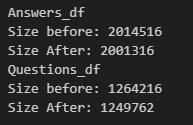

In [ ]:
# Here we see how many unique nodes there are in the dataset
unique_users = np.unique(np.asarray(np.append(clean_questions_df.get('OwnerUserId'),clean_answers_df.get('OwnerUserId')),dtype=int))
print(f'unique_nodes: {len(unique_users)}')

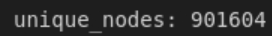

We subset the data by limiting to questions asked in 2009 and corresponding answers in the same year. It is noted that there should have been a '>=' sign instead of '>' in line 2 below and this is a code error, which will lead to unanswered questions (for questions posed in late 2009). Too late to change. We also drop answers to questions from 2008 or previous years

In [ ]:
subset_questions_df = questions_df[questions_df.CreationDate.str[:4].astype('int') == 2009]
subset_answers_df = answers_df[(2010 > answers_df.CreationDate.str[:4].astype('int')) & (answers_df.CreationDate.str[:4].astype('int') >= 2009)]

#make dict to ensure linear time instead of quadratic
subset_question_dict = {}
for ques in list(subset_questions_df.Id):
    subset_question_dict[ques] = True

## Drop Answers to Questions from 2008 or previous years
import tqdm
for ans_index in tqdm.tqdm(range(len(subset_answers_df)-1, -1,-1)):
    parid = subset_answers_df.iloc[ans_index].ParentId
    if not subset_question_dict.get(parid):
        subset_answers_df.drop(subset_answers_df.index[ans_index], inplace=True)
        #question_dict.get(subset_answers_df.iloc[ans_index].ParentId)

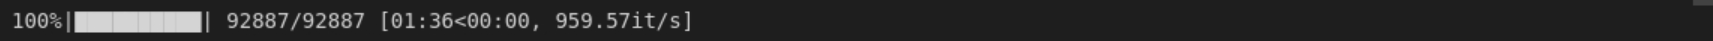
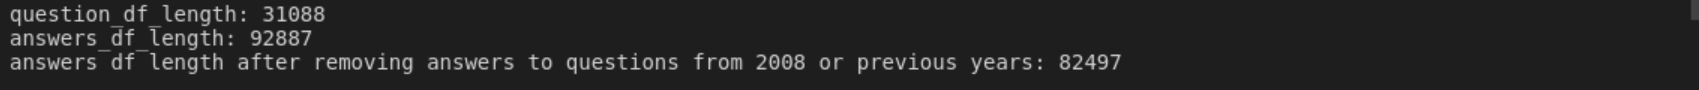

Now we can inspect total nodes in our final network,

In [ ]:
unique_users = np.unique(np.asarray(np.asarray(np.append(subset_questions_df.get('OwnerUserId'),subset_answers_df.get('OwnerUserId')),dtype=int),dtype=str))
print(f'unique_nodes: {len(unique_users)}')

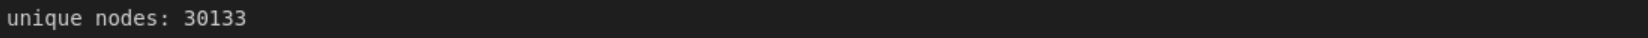

Now, The dataframe text is tokenized, bigrams are found using the function tokenize_col and dataframes are saved,

In [ ]:
import string
import nltk
from bs4 import BeautifulSoup
def tokenize_col(dat_frame_df,colname, calculate_bigrams):
    nltk.download('stopwords')
    nltk.download('punkt')
    #tok_list = []
    bad_tokens = set(['https:', 'http:', 'www.']) | set(nltk.corpus.stopwords.words('english')) | set(string.punctuation)
    bad_tokens_2 = set(string.punctuation) | set(['[',']','(',')','{','}','<','>','/','\\','|',')',']'])

    tok_list = []
    bi_list = []
    for i in range(len(dat_frame_df.get('OwnerUserId'))):
        body_text = dat_frame_df.iloc[i][colname]
        clean_body_text = BeautifulSoup(body_text, 'html.parser').get_text()
        #print(clean_body_text) 321
        if i % 5000 == 0:
            print(i)
        tokens = nltk.word_tokenize(clean_body_text)
        tokens = [token.lower() for token in tokens]
        remove_indexes = []
        for i in range(len(tokens)):
            #remove bad tokens
            if any([(tokens[i] == bad_token) for bad_token in bad_tokens]):
                remove_indexes.append(i)
            elif any([(bad_token in tokens[i]) for bad_token in bad_tokens_2]):
                remove_indexes.append(i)
            elif tokens[i].isnumeric():
                remove_indexes.append(i)            
        
        for i in range(len(remove_indexes) - 1, -1, -1):
            remove_index = remove_indexes[i]
            del tokens[remove_index]

        if len(tokens) == 1:
            tokens.remove(tokens[0])
            #Maybe do biagrams, if not too computationally demanding, to get temporal context
        
        if calculate_bigrams:
            bi_grams = list(nltk.bigrams(tokens))
            bi_list.append(bi_grams)
        tok_list.append(tokens)

    return tok_list if not calculate_bigrams else tok_list, bi_list


subset_questions_df['TitleTokens'], subset_questions_df['TitleBigrams']  = tokenize_col(subset_questions_df,colname='Title',calculate_bigrams=True)

subset_questions_df['Tokens'], subset_questions_df['TokensBigrams']  = tokenize_col(subset_questions_df,colname='Body',calculate_bigrams=True)

subset_answers_df['Tokens'], subset_answers_df['TokensBigrams']  = tokenize_col(subset_answers_df,colname='Body',calculate_bigrams=True)

subset_questions_df.to_csv('/work3/s204161/comp_social_science_data/subset_questions_c.csv', encoding='utf-8', index=False)
subset_answers_df.to_csv('/work3/s204161/comp_social_science_data/subset_answers_c.csv', encoding='utf-8', index=False)


Here is how the subsetted answers_df and question_df looks like,

In [ ]:
pd.set_option('display.max_rows', 6)
subset_answers_df

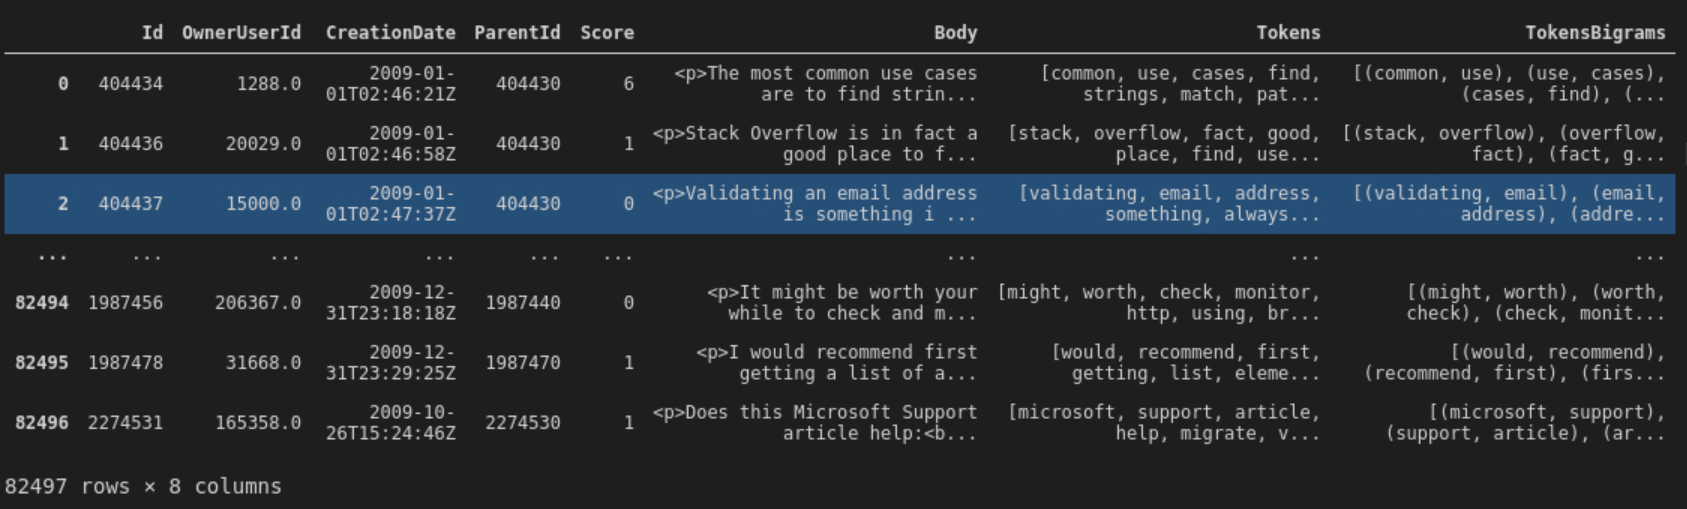

In [ ]:
subset_questions_df

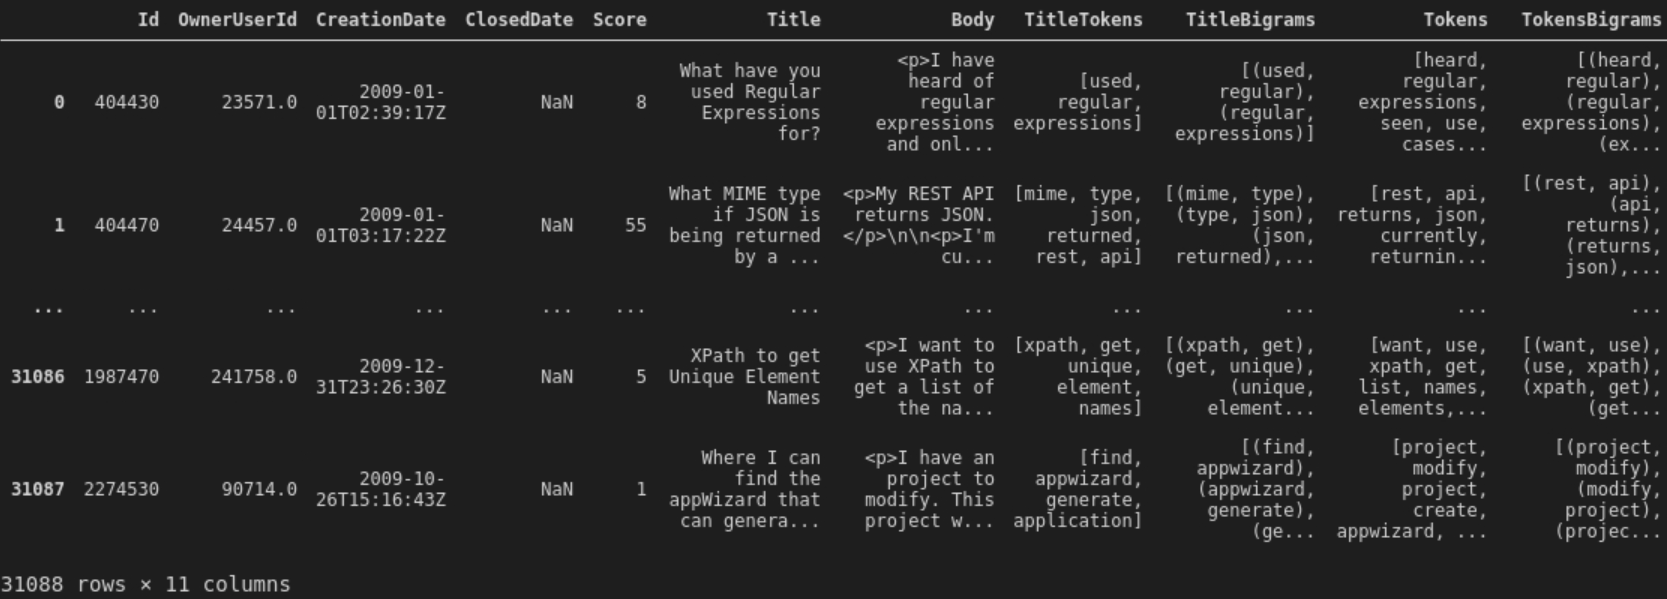

Now we make the social network as a directed graph, where nodes are users and a directed connection is when a person answers another persons question (also weighted such that multiple answers from one person to another are counted). To keep track of where a person answered another person, we add node attributes pertaining to the questions and answers a person has made, and these are kept track of by remembering postIDs of the questions/answers. To make it compact the structure is:

{node:{ questions:{ scores: {'ques_id1': 10, 'question_id2':5}}, answers:{  scores: {'answer_id1':2,'answer_id2':5} }}}

Where the innermost nested dict.values() are the scores of each respective post. First code cell adds information pertaining questions.

In [ ]:
import string
import nltk
from bs4 import BeautifulSoup
quest_attrs = {}

quest_found_bool = {}
#Add question/owner attributes to nodes:
for i in range(len(subset_questions_df.get('OwnerUserId'))):
    question_id = str(subset_questions_df.iloc[i].get('Id'))
    owner_id = str(int(subset_questions_df.iloc[i].get('OwnerUserId')))
    #If first time user is asking, create dict
    if not quest_found_bool.get(owner_id):
        quest_found_bool[owner_id] = True
        quest_attrs[owner_id] = {}
        quest_attrs[owner_id]['Scores'] = {}
    #owner_attrs[owner_id][question_id] = BeautifulSoup(subset_questions_df.iloc[i].get('Body'), 'html.parser').get_text()
    quest_attrs[owner_id]['Scores'][question_id] = (subset_questions_df.iloc[i].get('Score'))    
    #Should also save question title in graph - implement here:

    if i % 10000 == 0:
        print(i)
nx.set_node_attributes(G, quest_attrs, 'Questions')

The edges of the social network is also found and information/attributes pertaining answers are also added.

In [ ]:
answers_attrs = {}
answers_found_bool = {}

collab_network = {}

#Add answer attributes to nodes & remember that edge is directed from OwnerUserId --> OwnerUserId (parent):
for i in range(len(subset_answers_df.get('OwnerUserId'))):
    answers_id = str(subset_answers_df.iloc[i].get('Id'))
    owner_id = str(int(subset_answers_df.iloc[i].get('OwnerUserId')))
    post_parent_id = str(int(subset_answers_df.iloc[i].get('ParentId')))
    owner_parent_id = str(int(subset_questions_df[subset_questions_df.Id == int(post_parent_id)].OwnerUserId))
    #if first time user is answering create dict
    if not answers_found_bool.get(owner_id):
        answers_found_bool[owner_id] = True
        answers_attrs[owner_id] = {}
        answers_attrs[owner_id]['Scores'] = {}
    #owner_attrs[owner_id][answers_id] = BeautifulSoup(clean_answers_df.iloc[i].get('Body'), 'html.parser').get_text()

    if not collab_network.get((owner_id, owner_parent_id)):
        collab_network[(owner_id, owner_parent_id)] = 1
    else:
        collab_network[(owner_id, owner_parent_id)] += 1

    #we want to find scores for each person for answers too.
    answers_attrs[owner_id]['Scores'][answers_id] = subset_answers_df.iloc[i].get('Score')
    if i % 10000 == 0:
        print(i)

nx.set_node_attributes(G, answers_attrs, 'Answers')

edgelist = [(x[0][0], x[0][1], x[1]) for x in collab_network.items()]

G.add_weighted_edges_from(edgelist)

#save network before continuing:
import pickle
with open('/work3/s204161/comp_social_science_data/stackoverflow_subset_network.pickle', 'wb') as f:
    pickle.dump(G, f, protocol=pickle.HIGHEST_PROTOCOL)

Now additional information about the authors are found using the StackExchange API. It had to be done in 2 parts, since the rate limits are limited to 300 requests per day (up till 100 users can be retrieved per request), i.e. 30133 > 30000.

The kernel was shut down and the csv files were loaded into python at this point:

In [ ]:
import pandas as pd
import numpy as np
from ast import literal_eval

subset_questions_df = pd.read_csv('/work3/s204161/comp_social_science_data/subset_questions_c.csv', encoding='utf-8')
subset_answers_df = pd.read_csv('/work3/s204161/comp_social_science_data/subset_answers_c.csv', encoding='utf-8')

subset_answers_df.Tokens = subset_answers_df.Tokens.apply(lambda x: literal_eval(str(x)))
subset_answers_df.TokensBigrams = subset_answers_df.TokensBigrams.apply(lambda x: literal_eval(str(x)))

subset_questions_df.Tokens = subset_questions_df.Tokens.apply(lambda x: literal_eval(str(x)))
subset_questions_df.TokensBigrams = subset_questions_df.TokensBigrams.apply(lambda x: literal_eval(str(x)))
subset_questions_df.TitleTokens = subset_questions_df.TitleTokens.apply(lambda x: literal_eval(str(x)))
subset_questions_df.TitleBigrams = subset_questions_df.TitleBigrams.apply(lambda x: literal_eval(str(x)))

## part 1 and part 2 of requesting info about users,

unique_users = np.unique(np.asarray(np.asarray(np.append(subset_questions_df.get('OwnerUserId'),subset_answers_df.get('OwnerUserId')),dtype=int),dtype=str))
print(len(unique_users))
first_batch = unique_users[:29400]
print(len(first_batch))
second_batch = unique_users[29400:]
assert len(second_batch) + len(first_batch) == len(unique_users)

Requests was used together with the stackexchange api.

In [ ]:

# Since bandwith/quota is not very little compared to dataset size, only top author names are found instead of whole dataset. This code should be applied on top authors only then.
import requests
import time
params = {
    'pagesize': 100,
    'page': 1,
}
remaining_users = []
all_data = []
username_dict = {}
for user_index in range(29400,30200,100):
    unsuccesful_tries = 0
    url = f'https://api.stackexchange.com/2.3/users/{";".join(map(str, unique_users[user_index:user_index + 100]))}?site=meta.stackoverflow'
    #url = f'https://api.stackexchange.com/2.3/users/{61}?site=meta.stackoverflow'
    response = requests.get(url,params = params)
    while response.status_code != 200:
        print(f'Failed with status code: {response.status_code}')
        time.sleep(5)
        if unsuccesful_tries == 3:
            remaining_users.append(unique_users[user_index:user_index + 100])
            continue
    time.sleep(3)
    if response.json()['has_more']:
        print(f'oh no, there was more data, not fetched, at {user_index} to {user_index + 100}')
    data = response.json()['items']

    for data_point in data:
        all_data.append(data_point)


Since quite a portion of users have deleted their accounts/they no longer exist, it was not possible to retrieve information about all users in our subsetted data. The 'has_more' flag did not trigger, there were no 'packet size'/page size limitations.

In [ ]:
import json
with open('/work3/s204161/comp_social_science_data/first_part_response_0-29400.json') as f:
    part_1 = json.load(f)
with open('/work3/s204161/comp_social_science_data/second_part_response_29400-30133.json') as f:
    part_2 = json.load(f)

response_data = part_1 + part_2
print(len(response_data))

# Only about half of these users still exist - Their account must have been deleted:
### For example:
# https://meta.stackoverflow.com/users/100027/ Still Exists.
# https://meta.stackoverflow.com/users/100157/ Does not still exist
print(f'40~ or so of these dont exist, \n {unique_users[0:100]}')

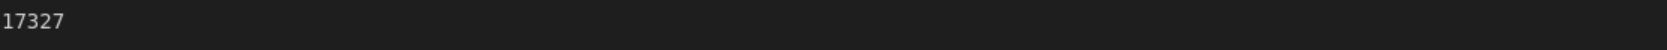
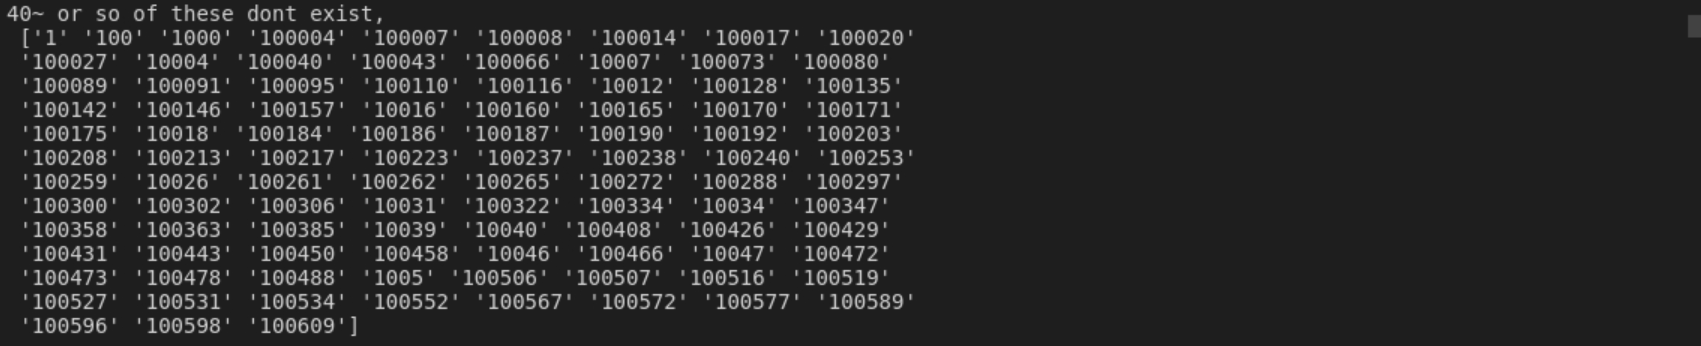

We add the extra information as network attributes and print an example node,

In [ ]:
# Pull out the values in response data we are interested in.
tot_users_attrs = {}
for user in response_data:
    user_attrs = {}
    user_id = str(user['user_id'])
    assert isinstance(user_id, str)
    user_attrs['user_name'] = user['display_name']
    user_attrs['user_type'] = user['user_type']
    user_attrs['location'] = user.get('location')
    user_attrs['reputation_today'] = user['reputation']
    user_attrs['badge_counts_today'] = user['badge_counts']

    tot_users_attrs[user_id] = user_attrs

#Add responses to network as node attributes.
import pickle
import community as community_louvain
nx.set_node_attributes(G, tot_users_attrs)

#save network w. response attrs.
with open(r'/work3/s204161/comp_social_science_data/stackoverflow_subset_network.pickle', 'wb') as f:
    pickle.dump(G, f, protocol=pickle.HIGHEST_PROTOCOL)

G.nodes['100297'] #example node

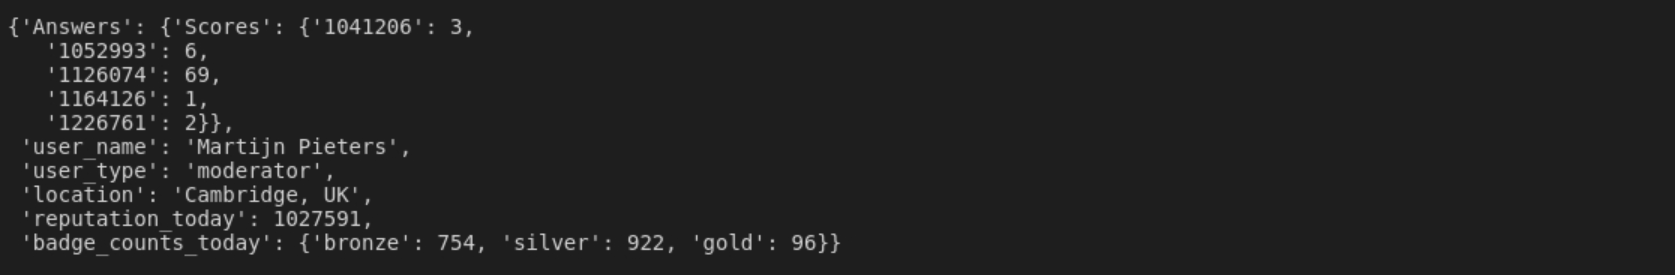

# 3. Tools, theory and analysis

# Louvain

In [ ]:
import networkx as nx
import community as community_louvain
import pickle
with open(r'/work3/s204161/comp_social_science_data/stackoverflow_subset_network_old.pickle', 'rb') as f:
    G = pickle.load(f)
G_un = G.to_undirected()
best_partition = community_louvain.best_partition(G_un)
num_communities = len(np.unique(list(best_partition.values()))) #Number of communities
print(f'num_communities: {num_communities}')
communities = {}
for num in range(num_communities):
    communities[num] = []

for node in best_partition:
    communities[best_partition[node]].append(node)


num_communities: 1079


In [ ]:
louvain_molarities = community_louvain.modularity(best_partition,G_un)
print("Louvain modularity:",louvain_molarities)

In [ ]:
import random
communities = {}
for node in best_partition:
    if best_partition[node] not in communities:
        communities[best_partition[node]] = [node]
    else:
        communities[best_partition[node]].append(node)

def modularity(G, communities):
    m = G.number_of_edges()
    q = {}
    for c in communities:
        lc = len(communities[c])
        kc = sum(G.degree(n) for n in communities[c])

        q[c] = lc/m - (kc/(2*m))**2
    return q

q = sum(modularity(G, communities).values())
conf_int = 1.96 * np.std(list(modularity(G, communities).values())) #Wald 95% CI for the expected modularity in a sampled community.
print(f'bad estimate! Wald CI modularity:{q} + - {conf_int}')

#non-parametric bootstrapped modularity estimate
def bootstrap_modularity(G, communities, n):
    q = []
    for i in range(n):
        new_communities = {}
        groups = list(communities.keys())
        sample_nums = random.choices(groups, k = len(groups))
        for c in communities:
             new_communities[c] = communities[sample_nums[c]]
        q.append(sum(modularity(G, new_communities).values()))
    return q
q_boot = bootstrap_modularity(G, communities, 1000)
#quantiles. 2.5% and 97.5%
q_boot.sort()
print(f'non-parametric boostrap 95% CI for modularity: [{q_boot[25]} , {q_boot[975]}]')
ci_lower = q_boot[25]
ci_upper = q_boot[975]

# plot histogram of bootstrap modularity estimates
plt.hist(q_boot, bins=30, color='black', density=True, ec = 'white')
plt.axvline(ci_lower, color='red', linestyle='dashed', linewidth=2)
plt.axvline(ci_upper, color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Modularity')
plt.ylabel('Frequency')
plt.title('Histogram of Bootstrap Modularity Estimates')
plt.show()

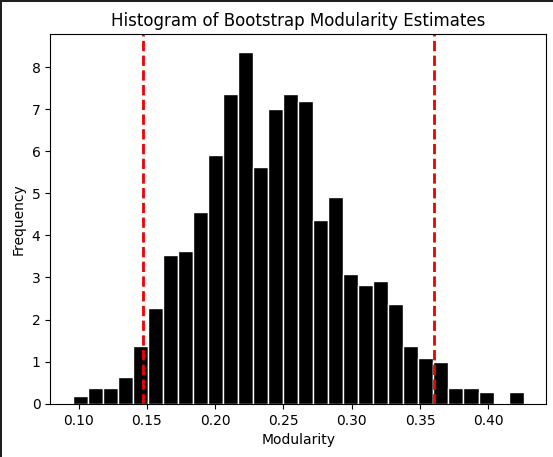

# Text-analysis
We extract community tokens and this is done for all tokens in community and also while seperating into tokens in questions and tokens in answers. Same with bigrams. Threading is used here for multi-processing to speed up things. By duplicating the tokens/bigrams in the question title, we are effectively weighting the question title higher and we would like to see how much it changes the results when alpha = 3 (artifically multiplying TF-IDF of terms in question_title by 3)

If there is time, we could compare vocabulary in questions with answers using wordclouds and/or sentiment analysis in a community.

In [ ]:
# c = community to extract tokens/bigrams for
def extract_community_tokens(communities, c, answers_df, questions_df, collect_answers_and_questions = True, multiply_title_weight = 1):
    sema.acquire()
    assert isinstance(multiply_title_weight,int)
    assert (multiply_title_weight > 0)
    answer_tokens, community_questions,community_answers = [],[],[]

    for user in communities[c]:

        user_questions = G.nodes[user].get('Questions')
        user_answers = G.nodes[user].get('Answers')
        if user_questions:
            user_question_ids = list(user_questions['Scores'].keys())
            community_questions += user_question_ids            
        if user_answers:
            user_answers_ids = list(user_answers['Scores'].keys())
            community_answers += user_answers_ids
        
    answers_tok = subset_answers_df[subset_answers_df['Id'].astype(str).isin(community_answers)].Tokens.tolist() 
    answers_bi = subset_answers_df[subset_answers_df['Id'].astype(str).isin(community_answers)].TokensBigrams.tolist() 
    questions_tok = subset_questions_df[subset_questions_df['Id'].astype(str).isin(community_questions)].Tokens.tolist()
    questions_bi = subset_questions_df[subset_questions_df['Id'].astype(str).isin(community_questions)].TokensBigrams.tolist()
    questions_title_tok = subset_questions_df[subset_questions_df['Id'].astype(str).isin(community_questions)].TitleTokens.tolist()
    questions_title_bigrams = subset_questions_df[subset_questions_df['Id'].astype(str).isin(community_questions)].TitleBigrams.tolist()
    
    answers_tok, answers_bi = [item for sublist in answers_tok for item in sublist], [item for sublist in answers_bi for item in sublist] 
    questions_tok, questions_bi, questions_title_tok, questions_title_bigrams = [item for sublist in questions_tok for item in sublist], [item for sublist in questions_bi for item in sublist], [item for sublist in questions_title_tok for item in sublist], [item for sublist in questions_title_bigrams for item in sublist] 

    multiply_title_weight -= 1
    while multiply_title_weight > 0:
        questions_title_tok.append(questions_title_tok)
        questions_title_bigrams.extend(questions_title_bigrams)
        multiply_title_weight -= 1

    all_tokens, all_bigrams = [],[]

    if collect_answers_and_questions:
        all_tokens.extend(questions_title_tok)
        all_tokens.extend(questions_tok)
        all_tokens.extend(answers_tok)
        
        all_bigrams.extend(questions_title_bigrams)
        all_bigrams.extend(questions_bi)
        all_bigrams.extend(answers_bi)
    else:
        questions_title_tok.extend(questions_tok)
        all_tokens.append(questions_title_tok)
        all_tokens.append(answers_tok)

        questions_title_bigrams.extend(questions_bi)
        all_bigrams.append(questions_title_bigrams)
        all_bigrams.append(answers_bi)

    with thread_lock:
        tok_arrays[c], bigram_arrays[c] = all_tokens, all_bigrams
    sema.release()
    return all_tokens, all_bigrams


In [ ]:
# Info about multiprocessing and threading in python: https://medium.com/python-experiments/parallelising-in-python-mutithreading-and-mutiprocessing-with-practical-templates-c81d593c1c49

sema = threading.Semaphore(value=16) #set maxthreads to to avoid out of memory error.

tok_arrays, bigram_arrays, thread_list = {}, {}, [] #thread_list used for multithreading
thread_lock = threading.Lock()
for c in communities:
    t = threading.Thread(target=extract_community_tokens, args=(communities, c, subset_answers_df, subset_questions_df,True))
    thread_list.append(t)
# start the threads
for thread in tqdm(thread_list):
    thread.start()
# wait for all threads to complete
for thread in thread_list:
    thread.join()

community_df = pd.DataFrame([tok_arrays]).T
community_df.columns = ['AllTokens']
community_df['AllBigrams'] = bigram_arrays

#Calculate again, but now using collect_answers_and_questions=False so tokens and bigrams are calculated for answers and questions.
tok_arrays, bigram_arrays, thread_list = {}, {}, []
thread_lock = threading.Lock()
for c in communities:
    t = threading.Thread(target=extract_community_tokens, args=(communities, c, subset_answers_df, subset_questions_df,False))
    thread_list.append(t)

for thread in tqdm(thread_list):
    thread.start()
for thread in thread_list:
    thread.join()

print('tok_array returned as [questions, answers]')        
community_df['QuestionsTokens'] = [tok_arrays[x][0] for x in tok_arrays]
community_df['AnswersTokens'] = [tok_arrays[x][1] for x in tok_arrays]
community_df['QuestionsBigrams'] = [bigram_arrays[x][0] for x in bigram_arrays]
community_df['AnswersBigrams'] = [bigram_arrays[x][1] for x in bigram_arrays]

#Multiply occurences in Question Title with alpha - weight Question Titles higher in TF-IDF.
alpha = 3 

tok_arrays, bigram_arrays, thread_list = {}, {}, []
thread_lock = threading.Lock()
for c in communities:
    t = threading.Thread(target=extract_community_tokens, args=(communities, c, subset_answers_df, subset_questions_df,True,alpha))
    thread_list.append(t)

for thread in tqdm(thread_list):
    thread.start()
for thread in thread_list:
    thread.join()


community_df_a3 = pd.DataFrame([tok_arrays]).T
community_df_a3.columns = ['AllTokens']
community_df_a3['AllBigrams'] = bigram_arrays

tok_arrays, bigram_arrays, thread_list = {}, {}, []
thread_lock = threading.Lock()
for c in communities:
    t = threading.Thread(target=extract_community_tokens, args=(communities, c, subset_answers_df, subset_questions_df,False,alpha))
    thread_list.append(t)

for thread in tqdm(thread_list):
    thread.start()
for thread in thread_list:
    thread.join()

print('tok_array returned as [questions, answers]')        
community_df_a3['QuestionsTokens_alpha_3'] = [tok_arrays[x][0] for x in tok_arrays]
community_df_a3['AnswersTokens_alpha_3'] = [tok_arrays[x][1] for x in tok_arrays]
community_df_a3['QuestionsBigrams_alpha_3'] = [bigram_arrays[x][0] for x in bigram_arrays]
community_df_a3['AnswersBigrams_alpha_3'] = [bigram_arrays[x][1] for x in bigram_arrays]


Calculate community sizes and save as dataframe containing community-wise info (tokens, bigrams & community size)

In [ ]:
#count number of members in each community using np.unique()
indexes, counts = np.unique(list(best_partition.values()), return_counts=True)
community_df['community_size'] = [0]*len(indexes)
community_df_a3['community_size'] = [0]*len(indexes)
for i in indexes:
    community_df['community_size'].loc[i] = counts[i]
    community_df_a3['community_size'].loc[i] = counts[i]
    

community_df.to_csv(r'/work3/s204161/comp_social_science_data/community_df.csv', index = False)
community_df_a3.to_csv(r'/work3/s204161/comp_social_science_data/community_df_alpha3.csv', index = False)


To load community_df in again.

In [ ]:
community_df = pd.read_csv('/work3/s204161/comp_social_science_data/community_df.csv', encoding='utf-8')
community_df_a3 = pd.read_csv('/work3/s204161/comp_social_science_data/community_df_alpha3.csv', encoding='utf-8')

community_df.AllTokens = community_df.AllTokens.apply(lambda x: literal_eval(str(x)))
community_df.AllBigrams = community_df.AllBigrams.apply(lambda x: literal_eval(str(x)))

community_df_a3.AllTokens = community_df_a3.AllTokens.apply(lambda x: literal_eval(str(x)))
community_df_a3.AllBigrams = community_df_a3.AllBigrams.apply(lambda x: literal_eval(str(x)))


Calculating TF- Token Frequency,

In [ ]:
#find top 9 communities by number of authors
top_9_communities = community_df.sort_values(by=['community_size'], ascending=False).iloc[:9]

#not clear if for each of 9 or across all 9 communities, across all is given:
#10 most frequent tokens in top 9 communities
fv = None
for i in range(9):
    fdist = nltk.FreqDist(top_9_communities['AllTokens'].iloc[i])
    if fv == None:
        fv = fdist
    else:
        fv = fv + fdist
fdist = fv
print(fdist.most_common(10))

#Token frequency distribution for each community:
flist = {}
for i in range(len(communities)):
    fdist = nltk.FreqDist(community_df['AllTokens'].loc[i])
    flist[i] = fdist

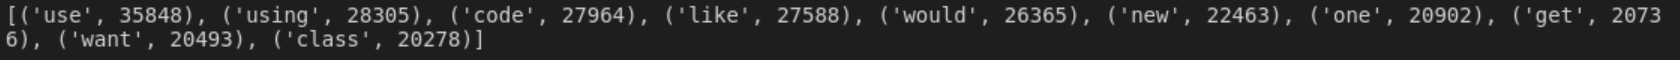

In [ ]:
top_9_communities

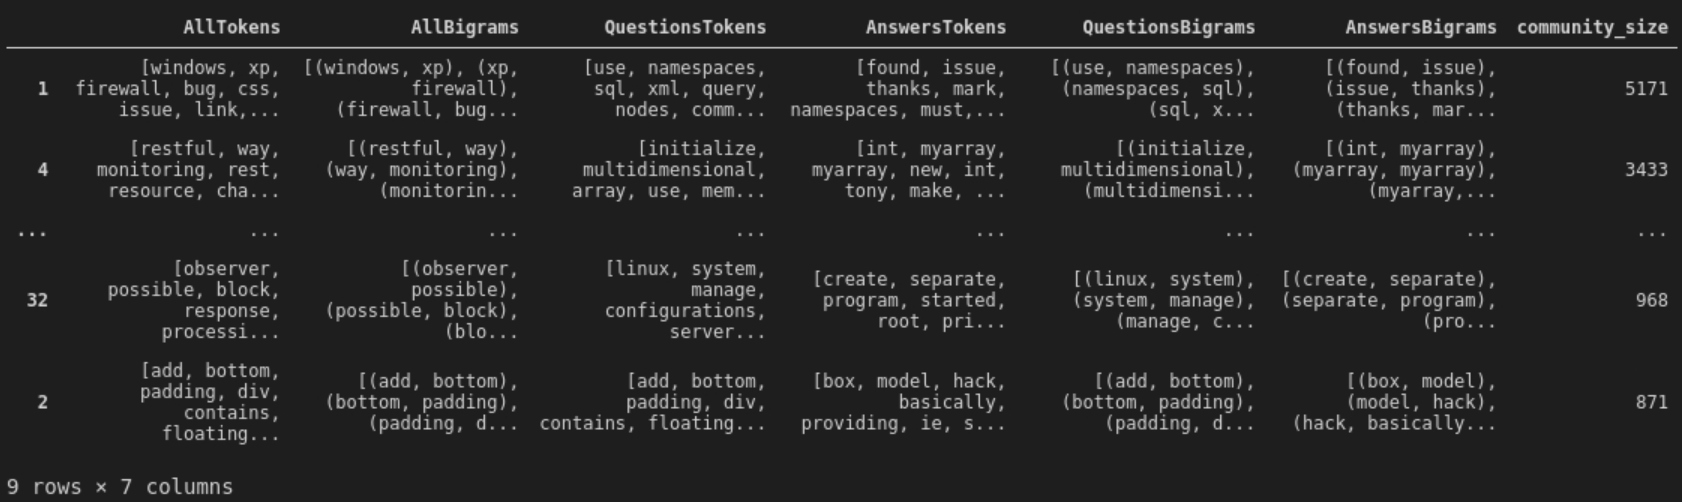

Calculating IDF - is done on HPC, takes too much time and RAM.

In [ ]:
#idf for each token in corpus.
import math
import itertools
from tqdm import tqdm

def idf_for_token(token, communities,community_df):
    
    #faster time complexity than code from b4
    n_t = sum(community_df['AllTokens'].apply(lambda x:token in x))
    
    idf = int(math.log(len(communities)/n_t,10))
    with thread_lock:
        idf_dict[token] = idf
    return idf

tok_list =community_df['AllTokens']
unique_tokens  = list(set(list(itertools.chain.from_iterable(tok_list))))

idf_dict, thread_list = {}, [] #thread_list used for multithreading
thread_lock = threading.Lock()

for token in unique_tokens:
    t = threading.Thread(target=idf_for_token, args=(token, communities, community_df))
    thread_list.append(t)
# start the threads
for thread in tqdm(thread_list):
    thread.start()
# wait for all threads to complete
for thread in thread_list:
    thread.join()


##  IF RAN USING HPC - USE MULTITHREAD